In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


In [2]:
train_file = "/kaggle/input/playground-series-s5e2/train.csv"
test_file = "/kaggle/input/playground-series-s5e2/test.csv"
train_extra_file = "/kaggle/input/playground-series-s5e2/training_extra.csv"

In [3]:
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
train_extra_data = pd.read_csv(train_extra_file)

In [4]:
train_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [5]:
train_extra_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


In [6]:
train_data.shape, train_extra_data.shape

((300000, 11), (3694318, 11))

In [7]:
data = pd.concat([train_data, train_extra_data], axis=0)

In [8]:
data.columns

Index(['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')

In [9]:
data.shape

(3994318, 11)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 365.7+ MB


In [11]:
data.isnull().mean()*100

id                      0.000000
Brand                   3.173458
Material                2.777996
Size                    2.197747
Compartments            0.000000
Laptop Compartment      2.466829
Waterproof              2.361454
Style                   2.608205
Color                   3.345177
Weight Capacity (kg)    0.045264
Price                   0.000000
dtype: float64

In [12]:
cat_cols = data.select_dtypes(include=['object']).columns
num_cols = data.select_dtypes(exclude=['object']).columns
id_cols = ['id']
target_col = ['target']

In [13]:
def dataTreatment(inp_dataframe):
    data = inp_dataframe.copy()
    data['Brand'] = data.Brand.fillna(data['Brand'].mode()[0])
    data['Material'] = data.Material.fillna(data['Material'].mode()[0])
    data['Size'] = data.Size.fillna(data['Size'].mode()[0])
    data['Style'] = data.Style.fillna(data['Style'].mode()[0])
    data['Color'] = data.Color.fillna(data['Color'].mode()[0])
    data['Weight Capacity (kg)'] = data['Weight Capacity (kg)'].fillna(data['Weight Capacity (kg)'].median())
    data['Waterproof'] = data.Waterproof.fillna(data['Waterproof'].mode()[0])
    data['Laptop Compartment'] = data['Laptop Compartment'].fillna(data['Laptop Compartment'].mode()[0])
    
    for col in cat_cols:
        dummies = pd.get_dummies(data[col], drop_first=True, dtype="int", prefix_sep="_", prefix=col)
        data = pd.concat([data, dummies], axis=1)
        data.drop(col, axis=1, inplace=True)
    data.head()
    
    data.rename(columns={'Weight Capacity (kg)': 'Weight'}, inplace=True)
    data['Weight'] = data['Weight'].apply(lambda x: round(x,2))
    data['Compartments'] = data['Compartments'].astype("int")
    
    return data
    

In [14]:
cleaned_data = dataTreatment(data)
cleaned_data.head()

,id,Compartments,Weight,Price,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,...,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
0,0,7,11.61,112.15875,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
1,1,10,27.08,68.88056,1,0,0,0,0,0,...,1,1,1,1,0,0,0,1,0,0
2,2,2,16.64,39.17320,0,0,0,1,1,0,...,1,1,0,1,0,0,0,0,0,1
3,3,8,12.94,80.60793,0,1,0,0,0,1,...,1,1,0,1,0,0,0,1,0,0
4,4,1,17.75,86.02312,0,0,0,0,0,0,...,0,1,1,1,0,0,0,1,0,0


In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [16]:
df_train, df_test = train_test_split(cleaned_data, test_size=0.2, random_state=56)

In [17]:
df_train.shape, df_test.shape

((3195454, 22), (798864, 22))

In [18]:
df_train.drop('id', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)

In [19]:
df_train.shape, df_test.shape

((3195454, 21), (798864, 21))

In [20]:
df_train.head()

,Compartments,Weight,Price,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,...,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
2836732,1,11.93,77.58826,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
2976330,3,20.95,119.08740,0,0,0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0
968160,3,10.13,35.45515,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,0,0
205482,9,27.64,78.85025,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2778176,9,9.93,73.22797,0,0,1,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0


In [21]:
scaler = MinMaxScaler()

In [22]:
scale_cols = ['Weight','Compartments']

In [23]:
df_train[scale_cols] = scaler.fit_transform(df_train[scale_cols])
df_train.head()

,Compartments,Weight,Price,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,...,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
2836732,0.000000,0.2772,77.58826,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
2976330,0.222222,0.6380,119.08740,0,0,0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0
968160,0.222222,0.2052,35.45515,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,0,0
205482,0.888889,0.9056,78.85025,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2778176,0.888889,0.1972,73.22797,0,0,1,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0


In [24]:
df_test[scale_cols] = scaler.transform(df_test[scale_cols])

In [25]:
y_train = df_train.pop('Price')
X_train = df_train

In [26]:
y_test = df_test.pop('Price')
X_test = df_test

In [27]:
X_train.head()

,Compartments,Weight,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,Size_Medium,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
2836732,0.000000,0.2772,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
2976330,0.222222,0.6380,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0
968160,0.222222,0.2052,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0
205482,0.888889,0.9056,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2778176,0.888889,0.1972,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

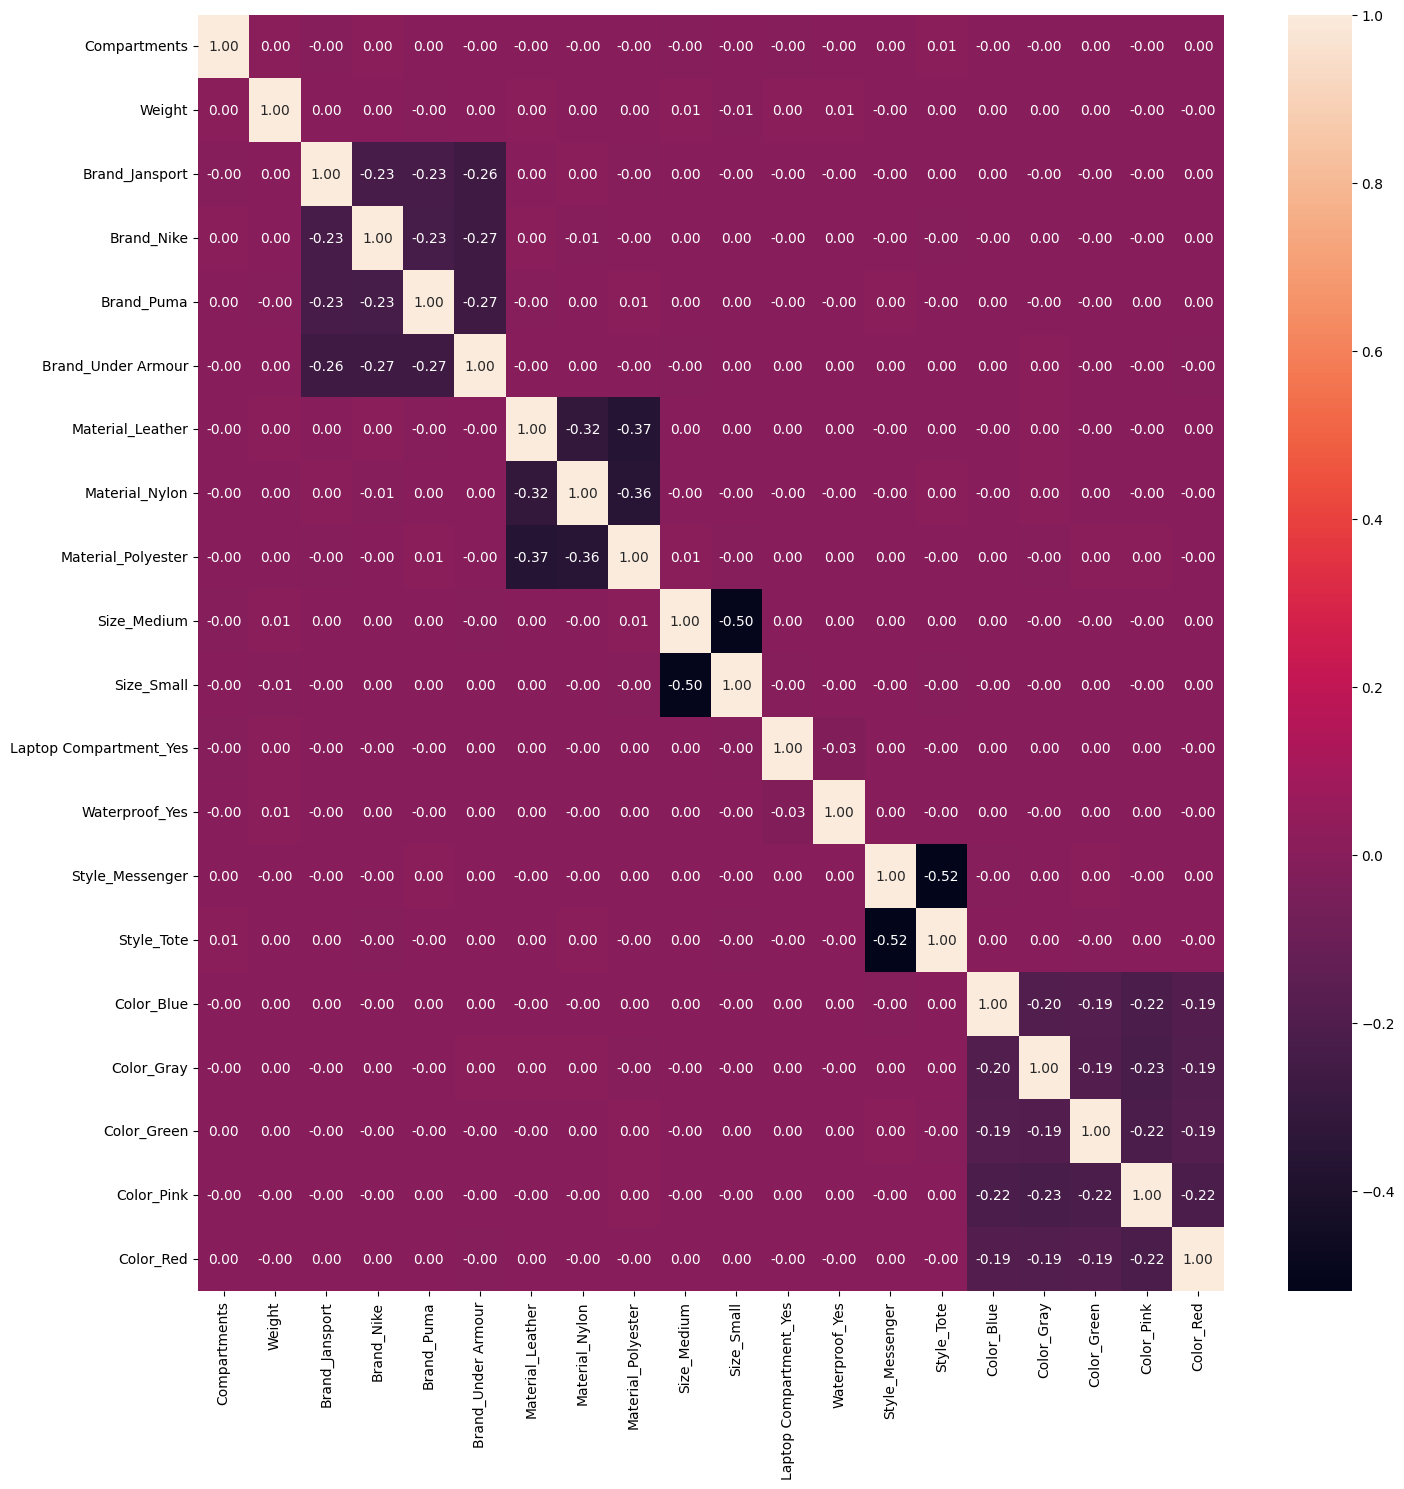

In [29]:
plt.figure(figsize=[15,15])
sns.heatmap(X_train.corr(), annot=True, fmt="0.2f")
plt.tight_layout()
plt.show()

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [31]:
cvs_lr = cross_val_score(lr_model, X_test, y_test, cv=3, scoring='neg_mean_squared_error')


rmse = np.sqrt(-cvs_lr)
print(rmse)

[38.97792811 38.98149817 38.8803524 ]


In [32]:
lr_model.predict(X_test)

array([80.29735358, 81.05826749, 79.35779034, ..., 80.47538433,
       78.89627911, 80.3281484 ])

In [33]:
clean_test_data = dataTreatment(test_data)
clean_test_data[scale_cols] = scaler.transform(clean_test_data[scale_cols])

In [34]:
clean_test_data.drop('id', axis=1, inplace=True)

In [35]:
predictions = lr_model.predict(clean_test_data)

In [36]:
results_df = pd.DataFrame({
    "id": test_data['id'],
    "Price": predictions
})

results_df.head()

,id,Price
0,300000,81.861697
1,300001,81.815939
2,300002,81.047333
3,300003,81.394936
4,300004,78.702890


In [37]:
results_df.to_csv("linear_reg_backpack.csv", index=False)